# Creation of semi-synthetic simulated data
The method is outlined in Wieder, C., Lai, R.P.J. & Ebbels, T.M.D. Single sample pathway analysis in metabolomics: performance evaluation and application. BMC Bioinformatics 23, 481 (2022). https://doi.org/10.1186/s12859-022-05005-1

The code is contained in ```simulate_pathway_signals.py```

### Peusdo-code 

Simulation 
- Look at different effect sizes
- Look at different pathway pairs

Step 1:
- Create null simulation (effect size = 0) 
    Shuffling was done in the simulation code
- Then bootstrap to begin on samples from the null simulation
- Function to use: pd.sample(replace= False) [because bootstrap is sampling without replacment] can sample rows randomly; set n to as many samples as you have (aka # of metabolites); axis =0 so it does reampling from the rows


Step 2:
- Run pipleline of building network 
    Create pathway scores
    Compute correlation matrix 
    Need to store correlation matrix in a list

Step 3:
- Compute mean and SD of each correlation matrix and compare to the null (so effect size x vs effect size 0); want to see the distribution of correlation (do a kernal density or histogram; overlay plots for all correlations)
- Do the z-score for each pair of pathways - will get one Z score for every pair of pathways (will represent how much the pair of pathways is deviating from the mean correlation)
- Compute p value from the z-score (can turn it into a p value with a function from SciPy)

Step 4:
- Change the effect size 0.5 step
- You get as many p values you have p values; you only get the p value of the enriched pathways - want to see does the correlation become significant

Step 5:
- Scatter plot of the original effect size vs the p value for the enriched pathway

Last step:
- AFTER RUN ONCE: Write a for loop to iterate to run it multiple times (10 times to start); when you make the outter loop you need variable outside where you store the correlation dataframes from every itteration; The loop is going to be on the entire pipeline
    Question: New null simulation everytime? - bootstrap creates variability, but if you also compute the null everytime you have a slightly different null distribution everytime; because there would be two levels of variability, need to ask Tim if we need 2 levels or variability or 1 is fine


In [1]:
# Import Packges 
import numpy as np
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import sklearn 
import sspa
import sspa.utils
import gseapy.plot as gp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px
import bioinfokit as bf
import networkx as nx
from sklearn.preprocessing import StandardScaler
import itertools
from simulate_pathway_signals import SimulateData
import statistics

# Loading datasets and dictionaries

In [2]:
# Make dictionary of the pathway and all the metabolites that define that pathway using ChEBI IDs
reactome_pathways = sspa.process_reactome("Homo sapiens", download_latest=True, filepath=".")
reactome_dict_metabolites = sspa.utils.pathwaydf_to_dict(reactome_pathways)
print("Number of possible pathways:", len(reactome_dict_metabolites))
print("type:",type(reactome_dict_metabolites))

Beginning Reactome download...
Reactome DB file saved to ./Reactome_Homo_sapiens_pathways_compounds_R83.gmt
Complete!
Number of possible pathways: 2040
type: <class 'dict'>


In [3]:
# Save data into variable ; name after authors; # Read CVS to important
# python 0 means the first thing, if you give it nothing it will give an index for you
# if it reads with pandas, it automatrically puts it into a pd.dataframe!! so you dont need to put it into a pandas data frame
su_data = pd.read_csv('/Users/sarapatti/Documents/Code MRes DS SP 2022-2023/Exported files/su_data_metabolites', index_col=0) # Proccesed data
su_data

,1372,16610,72665,27823,30915,37373,16831,545959,17050,16359,...,133693,133694,28036,28238,76341,89312,17861,89188,WHO_status,Group
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.822470,0.370169,0.537246,0.362243,-0.578361,-1.201938,-1.195697,-0.253528,0.237192,-0.502347,...,0.057068,0.228500,-0.546769,-0.587946,-0.175542,-0.693254,-1.201150,0.403074,0,Healthy Donor
1008097,0.149291,-0.802638,-1.220563,-0.774417,-0.123663,-0.453530,-0.956306,-0.805678,-0.840364,0.320534,...,0.565895,0.544281,-0.053133,-0.048306,-0.920090,-1.434730,-0.475391,0.134784,0,Healthy Donor
1008631,1.012771,-1.033291,0.145690,0.524050,-0.073503,-0.229649,1.475643,-0.437623,-0.827898,-0.462676,...,0.507601,1.009191,0.099614,0.508498,-1.272854,0.448616,1.207374,-0.637957,0,Healthy Donor
1012545,-0.979554,-0.395854,2.449097,0.866752,-0.354040,-0.345205,0.057663,-0.306422,-0.908367,-0.533817,...,-0.091666,0.782065,-0.341433,1.612615,0.851680,-0.504009,0.084370,-0.279907,0,Healthy Donor
1022407,-0.739817,-0.288710,-0.782552,-0.526128,0.288048,0.550284,-0.550971,-0.640346,-0.833565,-0.451067,...,0.233939,0.883763,-0.576132,-0.567979,-1.182109,-0.260231,-1.009292,-0.095161,0,Healthy Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135-BL,-2.228940,-0.101002,-0.679609,0.000163,0.284214,0.734004,-0.041038,-0.210435,0.070459,-0.374044,...,-0.525115,-0.495566,-0.182214,0.714288,-0.265526,-0.151931,1.330576,-1.105986,1-2,COVID19
INCOV136-BL,-0.169748,1.599117,0.173275,0.046243,-0.470655,1.219268,0.504222,1.204577,2.016911,0.431724,...,-0.768909,-0.829643,-0.247622,-1.579635,0.567450,-0.364475,1.220314,-0.755291,3-4,COVID19
INCOV137-BL,0.317113,0.383352,-0.981562,0.857227,-1.462299,0.594609,0.561018,-0.709397,0.361510,-0.550916,...,-1.380566,-1.338709,2.431694,0.961980,0.630608,-0.262134,0.475143,-1.235598,5-7,COVID19


In [4]:
# Computing coverage - which metabolites are in the dataset
su_data_nometa = su_data.iloc[:,:-2]
compounds_present = su_data_nometa.columns.tolist() #metabolites from oringal data set, using ChEBI IDs; turns the column names into a list
print("Number of metabolites from our data:", len(set(compounds_present))) # 333 metabolites

# All pathways in reactome
reactome_dict_metabolites = sspa.utils.pathwaydf_to_dict(reactome_pathways)
reactome_dict_metabolites_series = pd.Series(reactome_dict_metabolites) # Need to put into a series first

pathways_present_dict = {k: v for k, v in reactome_dict_metabolites_series.items() if len([i for i in compounds_present if i in v]) >= 2} 
pathways_present = pd.Series(pathways_present_dict)
# Make a dictionary with pathway names and metabolites
pathway_dictionary = pathways_present.to_dict()


Number of metabolites from our data: 333


In [5]:
# Chebi to me keys, names ot be values
list3 = reactome_pathways.index
list4 = reactome_pathways["Pathway_name"] 

# Make a dictionary with two lists 
reactome_dict = dict(zip(list3, list4)) # zip is a way of pulling two lists together (need to be same length) and put it into a tupple (pair of things)
reactome_dict

len(reactome_dict)

2291

# Enrichment

In [6]:
enriched_names = ['SLC transporter disorders', 'Metabolism of amino acids and derivatives']
enriched_names ## need put in pathway ID

print(list(reactome_dict.keys())[list(reactome_dict.values()).index('SLC transporter disorders')])
print(list(reactome_dict.keys())[list(reactome_dict.values()).index('Metabolism of amino acids and derivatives')])

enriched = ['R-HSA-5619102', 'R-HSA-71291']
enriched

# overlap of pathways = 0.3, abs_correlation = 0.787682

R-HSA-5619102
R-HSA-71291


['R-HSA-5619102', 'R-HSA-71291']

In [7]:
type(pathway_dictionary)
print("Number of metabolites in R-HSA-5619102:", len(pathway_dictionary["R-HSA-5619102"]))
print("Number of metabolites in R-HSA-71291:", len(pathway_dictionary["R-HSA-71291"]))

Number of metabolites in R-HSA-5619102: 83
Number of metabolites in R-HSA-71291: 300


# Data Simulation

In [8]:
sd = SimulateData(
    input_data=[su_data.iloc[:,:-2]],
    metadata=[su_data['Group']],
    pathways=pathway_dictionary,
    enriched_paths=enriched)
sd

In [9]:
# Calculating for a single one
sim_data = sd.enrich_paths_base
sim_data_null = sd.enrich_paths_base(effect=0)
# this is where the simulated data is stored
# effect side is adding the constant; its keeping all the other correlations outside of the ones chosen as enriched
# This data matrix would replace the original COVID one 
metab_sim_null = sim_data_null[0]
metab_sim_null = metab_sim_null.iloc[:,:-1] # remove group

# Null (Effect size = 0) - Bootstrap, Pathway Analysis, Correlation Matrix, Mean & Stdev

In [10]:
# Calculating bootstrap for effect size = 0 [null]
bootstrap_resampling = metab_sim_null.sample(n=263,replace=False, axis=0) # its shuffling patient samples 

## Bootstrap multiple times for null 
n_replicates = 100
bootstap_list_n = []
for i in range(n_replicates):
    resampling_bootstap = metab_sim_null.sample(n=263,replace=True, axis=0)
    bootstap_list_n.append(resampling_bootstap)
len(bootstap_list_n)

100

In [11]:
# Confirming bootstrap is different

boot_1 = bootstap_list_n[5]
boot_2 = bootstap_list_n[55]
boot_3 = bootstap_list_n[98]

boot_1_counts = pd.DataFrame(boot_1.value_counts("sample_id"), columns=["Count"])
boot_1_counts=boot_1_counts.reset_index()

boot_2_counts = pd.DataFrame(boot_2.value_counts("sample_id"), columns=["Count"])
boot_2_counts=boot_2_counts.reset_index()

boot_3_counts = pd.DataFrame(boot_3.value_counts("sample_id"), columns=["Count"])
boot_3_counts=boot_3_counts.reset_index()

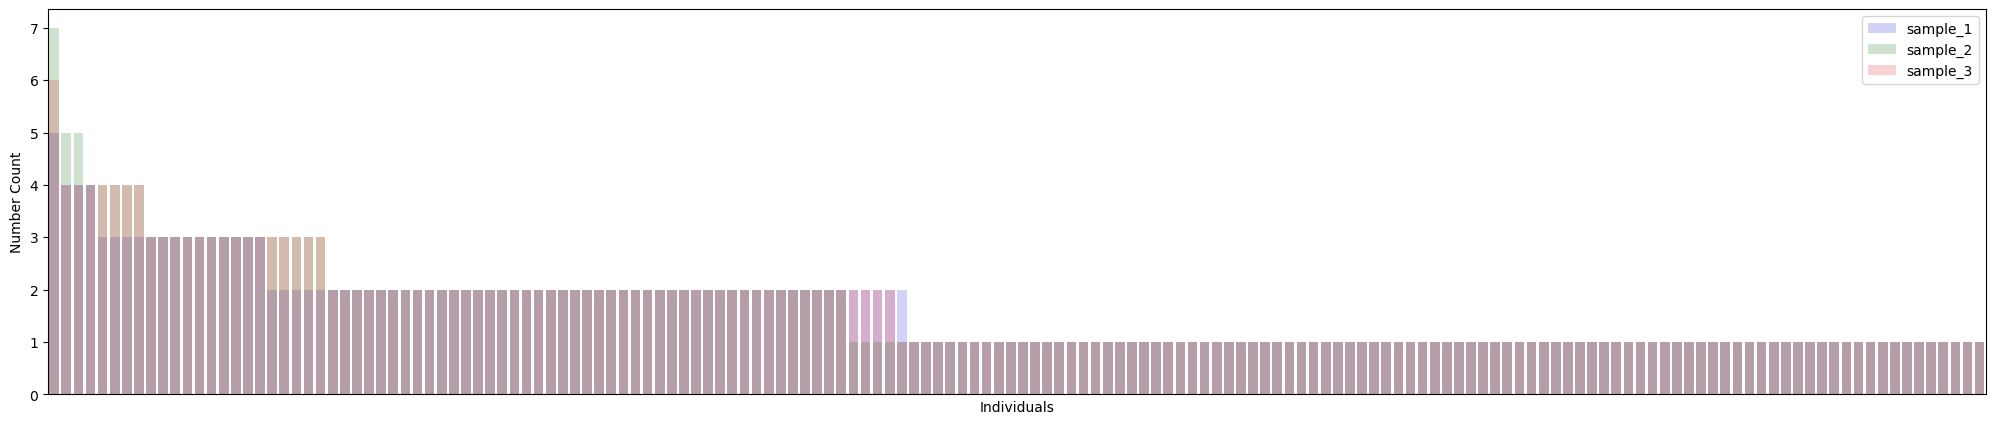

In [12]:
# Overlaping plots

# Creating subplots
ax= plt.subplots(figsize=(25,5))

# ploting columns
ax = sns.barplot(x = boot_1_counts["sample_id"], y= boot_1_counts["Count"], color= 'b', alpha = 0.2, label='sample_1')
ax = sns.barplot(x = boot_2_counts["sample_id"], y= boot_2_counts["Count"], color= 'g', alpha = 0.2, label='sample_2')
ax = sns.barplot(x = boot_3_counts["sample_id"], y= boot_3_counts["Count"], color= 'r', alpha = 0.2, label='sample_3')

# renaming thr axes
ax.set(xlabel="Individuals", ylabel="Number Count")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

# Visualizing graph
plt.legend()
plt.show()


In [13]:
# Making correlation matrix for null - bootstrapping

null_correlation_matrix_list = []
null_stack_correlation_matrix_list = []
for n in bootstap_list_n:
    kpca_scores= sspa.sspa_kpca(n, reactome_pathways)
    correlation_t_test, pval = stats.spearmanr(kpca_scores, axis=0, nan_policy='propagate', alternative='two-sided')
    correlation_t_test_df = pd.DataFrame(correlation_t_test, columns = kpca_scores.columns, index=kpca_scores.columns)
    null_correlation_matrix_list.append(correlation_t_test_df)
    corr = correlation_t_test_df.stack().reset_index()
    corr.columns = ["Pathway_1", "Pathway_2", "Correlation"]
    corr["Correlation_abs"]= abs(corr["Correlation"])
    null_stack_correlation_matrix_list.append(corr)


In [14]:
print("Null Correlation Matrix", len(null_correlation_matrix_list))
print("Null Stacked Correlation Matrix", len(null_stack_correlation_matrix_list))

Null Correlation Matrix 100
Null Stacked Correlation Matrix 100


In [15]:
# Labels for pathways
pathway_labels = null_stack_correlation_matrix_list[0]
pathway_labels

,Pathway_1,Pathway_2,Correlation,Correlation_abs
0,R-HSA-110331,R-HSA-110331,1.000000,1.000000
1,R-HSA-110331,R-HSA-112310,-0.574740,0.574740
2,R-HSA-110331,R-HSA-112311,-0.393313,0.393313
3,R-HSA-110331,R-HSA-112315,-0.587532,0.587532
4,R-HSA-110331,R-HSA-112316,-0.587525,0.587525
...,...,...,...,...
27220,R-HSA-975634,R-HSA-9735804,0.091759,0.091759
27221,R-HSA-975634,R-HSA-9748784,0.006645,0.006645
27222,R-HSA-975634,R-HSA-9749641,-0.102932,0.102932
27223,R-HSA-975634,R-HSA-9753281,0.096170,0.096170


In [16]:
# Drop pathway_1, pathway_2, and correlation from all the dataframes
listdfs = [df.drop(["Pathway_1", "Pathway_2", "Correlation"], axis = 1) for df in null_stack_correlation_matrix_list]
print("Number of null matrix:", len(listdfs))
contact = pd.concat(listdfs, axis = 1)
print("Null: # of correlations and # of matrix", contact.shape)

# Calculate mean and sd
mean_correlation = contact.mean(axis=1)
std_correlation = contact.std(axis=1)
mean_and_std_df = pd.DataFrame({"Mean": mean_correlation, "Std" : std_correlation})
pathway_mean_and_std_df = pd.merge(pathway_labels[["Pathway_1", "Pathway_2"]], mean_and_std_df, right_index= True, left_index= True)
pathway_mean_and_std_df

## Is there a good way to viziualize this?

Number of null matrix: 100
Null: # of correlations and # of matrix (27225, 100)


,Pathway_1,Pathway_2,Mean,Std
0,R-HSA-110331,R-HSA-110331,1.000000,1.222315e-16
1,R-HSA-110331,R-HSA-112310,0.320239,1.816498e-01
2,R-HSA-110331,R-HSA-112311,0.375219,6.450182e-02
3,R-HSA-110331,R-HSA-112315,0.434103,1.473007e-01
4,R-HSA-110331,R-HSA-112316,0.434101,1.473011e-01
...,...,...,...,...
27220,R-HSA-975634,R-HSA-9735804,0.062191,4.347414e-02
27221,R-HSA-975634,R-HSA-9748784,0.051057,4.725560e-02
27222,R-HSA-975634,R-HSA-9749641,0.098202,5.964241e-02
27223,R-HSA-975634,R-HSA-9753281,0.053103,4.162601e-02


# Effect Size Varriation

In [18]:
# Label for what the effect size is
effect_size_labels = []
i = 0
while i < 3:
    i = i+0.1
    effect_size_labels.append(i)

effect_size_labels =  [round(x,2) for x in effect_size_labels] 
effect_size_labels

j = 0
effect_size_index = []
for j in range(30):
    effect_size_index.append(j)
    j = j+1

effect_size_index_df = pd.DataFrame(effect_size_index, columns= ["Effect Index"])
len(effect_size_index_df)
effect_size_labels_df = pd.DataFrame(effect_size_labels, columns= ["Effect Size"])
len(effect_size_labels_df)

effect_size_labels_and_index = pd.merge(effect_size_index_df, effect_size_labels_df, right_index= True, left_index= True)
effect_size_labels_and_index
# effect_size_labels_and_index_transpose = effect_size_labels_and_index.transpose()

,Effect Index,Effect Size
0,0,0.1
1,1,0.2
2,2,0.3
3,3,0.4
4,4,0.5
5,5,0.6
6,6,0.7
7,7,0.8
8,8,0.9
9,9,1.0


In [19]:
# Write a loop for effect size 0 to 100 with 0.5 step
i = 0 
effect_size = []
while i < 3:
    sim_data_effect = sd.enrich_paths_base(effect=i)
    metab_sim = sim_data_effect[0]
    metab_sim = metab_sim.iloc[:,:-1]
    i = i+0.1
    effect_size.append(metab_sim)
print(len(effect_size))

## also interested between 0.1, add the tiny effect size so where youd see most difference
# while loop only does integers
# go between 0-2 with step size 0.1 


30


In [20]:
# Making correlation matrix for effect sizes - each matrix is for a different effect size

correlation_matrix_list = []
stack_correlation_matrix_list = []
for n in effect_size:
    kpca_scores= sspa.sspa_kpca(n, reactome_pathways)
    correlation_t_test, pval = stats.spearmanr(kpca_scores, axis=0, nan_policy='propagate', alternative='two-sided')
    correlation_t_test_df = pd.DataFrame(correlation_t_test, columns = kpca_scores.columns, index=kpca_scores.columns)
    correlation_matrix_list.append(correlation_t_test_df)
    corr = correlation_t_test_df.stack().reset_index()
    corr.columns = ["Pathway_1", "Pathway_2", "Correlation"]
    corr["Correlation_abs"]= abs(corr["Correlation"])
    stack_correlation_matrix_list.append(corr)

In [21]:
print("Number of Correlation Matrix (one per effect size)", len(correlation_matrix_list))
print("Number Stacked Correlation Matrix (one per effect size)", len(stack_correlation_matrix_list))

# correlation_matrix_list[100]
# stack_correlation_matrix_list[100]

Number of Correlation Matrix (one per effect size) 30
Number Stacked Correlation Matrix (one per effect size) 30


# Z score and signficance calculation

In [22]:
# Define z score : z score = (x - mean from null boostrap)/ (std from null bootstrap)
def z_score_calc(xcritical, mean, stdev):
    return (xcritical-mean)/stdev

In [23]:
# Effect size 5 - proof of coding example
effect_size_10 = z_score_calc(stack_correlation_matrix_list[10]["Correlation_abs"], pathway_mean_and_std_df["Mean"], pathway_mean_and_std_df["Std"])
effect_size_10 = pd.DataFrame(effect_size_10, columns=["Z-score"])
effect_size_10 = pd.merge(pathway_mean_and_std_df[["Pathway_1", "Pathway_2"]], effect_size_10, right_index= True, left_index= True)
effect_size_10

,Pathway_1,Pathway_2,Z-score
0,R-HSA-110331,R-HSA-110331,-1.816590
1,R-HSA-110331,R-HSA-112310,1.152885
2,R-HSA-110331,R-HSA-112311,2.180950
3,R-HSA-110331,R-HSA-112315,0.692393
4,R-HSA-110331,R-HSA-112316,0.692403
...,...,...,...
27220,R-HSA-975634,R-HSA-9735804,6.188060
27221,R-HSA-975634,R-HSA-9748784,8.854630
27222,R-HSA-975634,R-HSA-9749641,7.488970
27223,R-HSA-975634,R-HSA-9753281,2.089054


In [24]:
# Calculate z-score for each effect size
z_scores_effect_sizes = []
for m in stack_correlation_matrix_list:
    z_scores = z_score_calc(m["Correlation_abs"], pathway_mean_and_std_df["Mean"], pathway_mean_and_std_df["Std"])
    z_scores = pd.DataFrame(z_scores, columns=["Z-score"])
    z_scores_df = pd.merge(pathway_mean_and_std_df[["Pathway_1", "Pathway_2"]], z_scores, right_index= True, left_index= True)
    z_scores_df["Z-score_abs"] = abs(z_scores_df["Z-score"]) 
    z_scores_effect_sizes.append(z_scores_df)

print("Number of matrix for Z score - one per effect size", len(z_scores_effect_sizes))
z_scores_effect_sizes[2]

Number of matrix for Z score - one per effect size 30


,Pathway_1,Pathway_2,Z-score,Z-score_abs
0,R-HSA-110331,R-HSA-110331,-1.816590,1.816590
1,R-HSA-110331,R-HSA-112310,0.164011,0.164011
2,R-HSA-110331,R-HSA-112311,0.442473,0.442473
3,R-HSA-110331,R-HSA-112315,0.383823,0.383823
4,R-HSA-110331,R-HSA-112316,0.383834,0.383834
...,...,...,...,...
27220,R-HSA-975634,R-HSA-9735804,-0.976135,0.976135
27221,R-HSA-975634,R-HSA-9748784,-0.625120,0.625120
27222,R-HSA-975634,R-HSA-9749641,0.330618,0.330618
27223,R-HSA-975634,R-HSA-9753281,-1.039949,1.039949


In [25]:
# Calculate p-value for each effect size
p_values_effect_size = []
for m in z_scores_effect_sizes:
    p_values_one_sided = stats.norm.sf(m["Z-score_abs"]) # one sided
    p_values_two_sided = stats.norm.sf(m["Z-score_abs"])*2 # two sided
    p_values_df = pd.DataFrame({"p_values_one_sided": p_values_one_sided, "p_values_two_sided" : p_values_two_sided})
    p_values_df = pd.merge(pathway_mean_and_std_df[["Pathway_1", "Pathway_2"]], p_values_df, right_index= True, left_index= True)
    p_values_effect_size.append(p_values_df)

len(p_values_effect_size)
p_values_effect_size[2]

# Survival function - why is that what I use to get a p value from a Z score? - 

,Pathway_1,Pathway_2,p_values_one_sided,p_values_two_sided
0,R-HSA-110331,R-HSA-110331,0.034640,0.069280
1,R-HSA-110331,R-HSA-112310,0.434861,0.869722
2,R-HSA-110331,R-HSA-112311,0.329074,0.658147
3,R-HSA-110331,R-HSA-112315,0.350555,0.701110
4,R-HSA-110331,R-HSA-112316,0.350551,0.701102
...,...,...,...,...
27220,R-HSA-975634,R-HSA-9735804,0.164499,0.328997
27221,R-HSA-975634,R-HSA-9748784,0.265946,0.531892
27222,R-HSA-975634,R-HSA-9749641,0.370466,0.740933
27223,R-HSA-975634,R-HSA-9753281,0.149182,0.298364


In [26]:
# Drop pathway_1, pathway_2, and one_sided p value from all the dataframes 
listdfs_p = [df.drop(["Pathway_1", "Pathway_2", "p_values_one_sided"], axis = 1) for df in p_values_effect_size]
print("Number of null matrix:", len(listdfs_p))
contact_p = pd.concat(listdfs_p, axis = 1)
print("Null: # of correlations and # of matrix", contact_p.shape)

Number of null matrix: 30
Null: # of correlations and # of matrix (27225, 30)


In [27]:
# Rename effect_size_labels
contact_p.set_axis(effect_size_labels_and_index["Effect Size"], axis=1, inplace=True)
contact_p_path = pd.merge(pathway_mean_and_std_df[["Pathway_1", "Pathway_2"]],contact_p, right_index=True, left_index=True)
contact_p_path

,Pathway_1,Pathway_2,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0
0,R-HSA-110331,R-HSA-110331,0.069280,0.069280,0.069280,0.069280,0.069280,0.069280,0.069280,0.069280,...,6.927988e-02,6.927988e-02,6.927988e-02,6.927988e-02,6.927988e-02,6.927988e-02,6.927988e-02,6.927988e-02,6.927988e-02,6.927988e-02
1,R-HSA-110331,R-HSA-112310,0.870563,0.966195,0.869722,0.681632,0.825299,0.777380,0.800885,0.600301,...,3.120883e-01,7.183945e-01,1.384846e-02,4.917815e-02,8.993063e-01,1.361886e-02,6.206660e-02,4.189327e-02,3.925926e-02,7.578200e-01
2,R-HSA-110331,R-HSA-112311,0.823885,0.821848,0.658147,0.811124,0.921878,0.922002,0.683646,0.631473,...,2.634617e-02,2.101327e-07,1.036331e-06,6.817468e-06,2.702844e-01,1.456352e-06,8.116236e-02,1.732563e-06,3.122313e-09,6.298839e-06
3,R-HSA-110331,R-HSA-112315,0.663532,0.686185,0.701110,0.739430,0.790865,0.903830,0.788116,0.241564,...,4.241999e-01,1.410320e-02,2.423718e-02,1.037083e-01,6.492392e-01,2.521513e-02,1.089174e-01,8.303941e-02,8.824117e-02,5.884437e-01
4,R-HSA-110331,R-HSA-112316,0.663525,0.686177,0.701102,0.739421,0.790856,0.903821,0.788125,0.241570,...,4.241943e-01,1.410394e-02,2.423684e-02,1.037068e-01,6.492487e-01,2.521477e-02,1.089158e-01,8.303818e-02,8.823987e-02,5.884366e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27220,R-HSA-975634,R-HSA-9735804,0.778139,0.670472,0.328997,0.159646,0.882207,0.678998,0.767712,0.130892,...,4.304315e-06,8.139958e-13,1.562928e-37,1.180889e-48,5.361904e-01,1.207136e-46,2.191864e-15,3.978406e-46,1.156811e-19,6.179926e-01
27221,R-HSA-975634,R-HSA-9748784,0.303772,0.289406,0.531892,0.653557,0.465542,0.303952,0.026099,0.000929,...,4.513984e-01,5.273371e-10,1.754582e-45,3.542736e-46,6.746528e-11,3.915009e-36,1.258751e-38,6.608026e-31,1.531550e-47,7.285726e-09
27222,R-HSA-975634,R-HSA-9749641,0.790108,0.849449,0.740933,0.780966,0.239141,0.021189,0.007190,0.000036,...,4.692969e-12,1.008448e-02,2.939342e-25,5.332622e-27,8.467299e-12,2.407944e-19,1.298402e-14,4.195701e-16,2.391486e-31,4.114323e-21
27223,R-HSA-975634,R-HSA-9753281,0.450468,0.436835,0.298364,0.224488,0.234156,0.376519,0.644731,0.294414,...,2.512778e-01,3.898136e-01,6.524581e-01,7.032857e-01,7.674621e-01,4.238562e-01,6.283902e-01,3.125116e-01,2.729674e-01,6.332456e-01


In [55]:
#Dataframe of just enriched pathways ['R-HSA-5619102', 'R-HSA-71291']

enriched_path = contact_p_path.loc[contact_p_path['Pathway_1'] == 'R-HSA-5619102']
enriched_paths = enriched_path.loc[enriched_path['Pathway_2'] == 'R-HSA-71291']
enriched_paths_1 = enriched_paths.iloc[:,2:]
enriched_paths_melt = pd.melt(enriched_paths_1)


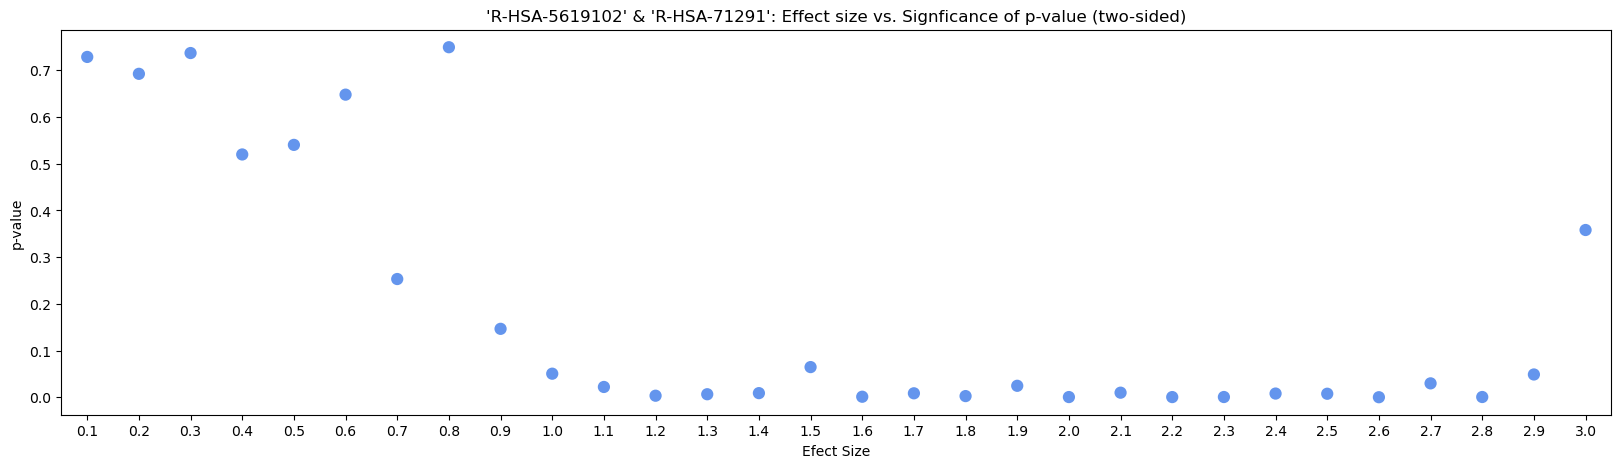

In [58]:
# Vizualize
plt.figure(figsize=(20,5))
sns.pointplot(data=enriched_paths_melt, x="variable", y="value", color = "cornflowerblue", errorbar =('ci', 100), join=False)
plt.xlabel("Efect Size")
plt.ylabel("p-value")
plt.title("'R-HSA-5619102' & 'R-HSA-71291': Effect size vs. Signficance of p-value (two-sided)")
plt.show()

In [38]:
# Melt the data
filtered_contact_p_path = contact_p_path.iloc[:, 2:6]
filtered_contact_p_path_melt = pd.melt(filtered_contact_p_path)
filtered_contact_p_path_melt

# melt pivots a dataframe; make a column from ; get variable and value 
# transpose flips and x and y, but melting makes it into longform data from wide form data; every column isnt a observation but an ID variable and the value variable 
# need melt for ggplots and other vizualization

,variable,value
0,0.1,0.069280
1,0.1,0.870563
2,0.1,0.823885
3,0.1,0.663532
4,0.1,0.663525
...,...,...
108895,0.4,0.159646
108896,0.4,0.653557
108897,0.4,0.780966
108898,0.4,0.224488


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Effect size 0.1 to 3 (stepsize = 0.1)')

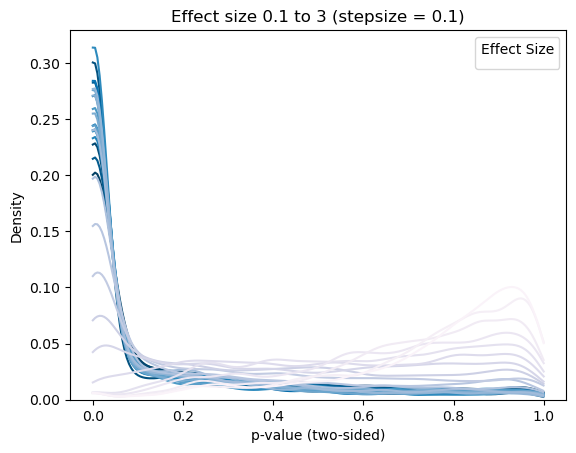

In [39]:
# Look at p-values
ax = sns.kdeplot(data=contact_p, legend= True, cut = 0, palette= 'PuBu')
ax.legend(loc='upper right',ncol=5, title="Effect Size" )

plt.title("Effect size - p-value")
plt.xlabel("p-value (two-sided)")
plt.title("Effect size 0.1 to 3 (stepsize = 0.1)")

# cut = 0 ; stops it at the min and max of the data
# do a scatter plot - x axis as effect size and y be p value

In [40]:
# Melt all the data
contact_p_path_loc = contact_p_path.iloc[:,2:] # dont need the pathway info

contact_p_path_melt = pd.melt(contact_p_path_loc)
contact_p_path_melt

,variable,value
0,0.1,6.927988e-02
1,0.1,8.705630e-01
2,0.1,8.238848e-01
3,0.1,6.635323e-01
4,0.1,6.635246e-01
...,...,...
816745,3.0,6.179926e-01
816746,3.0,7.285726e-09
816747,3.0,4.114323e-21
816748,3.0,6.332456e-01


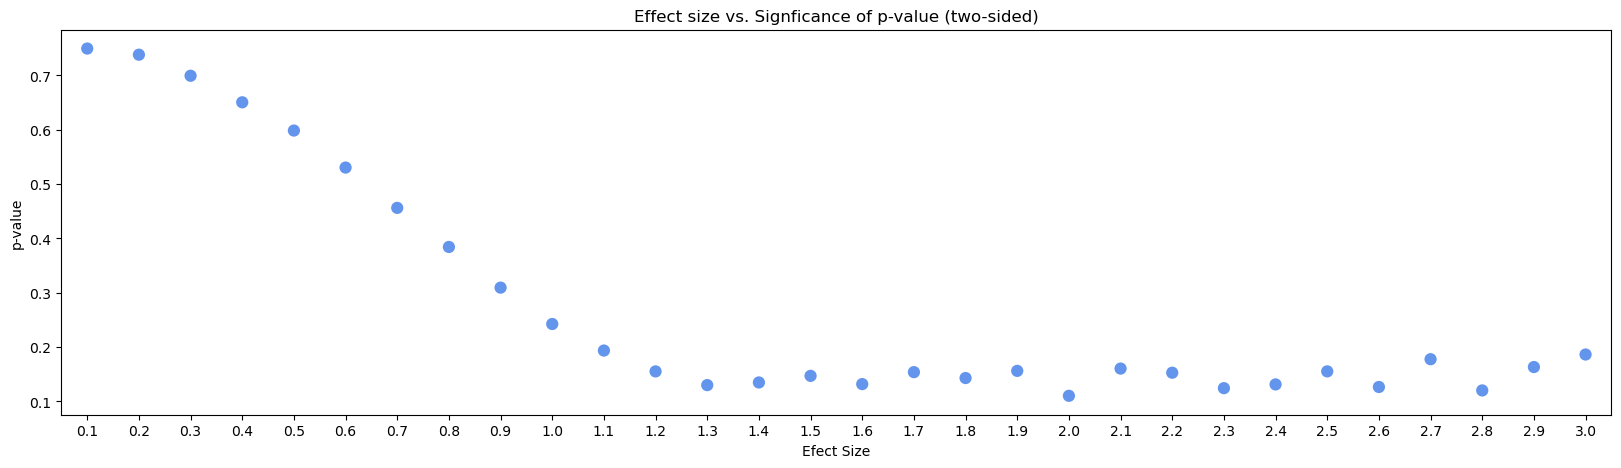

In [41]:
# Vizualize
plt.figure(figsize=(20,5))
sns.pointplot(data=contact_p_path_melt, x="variable", y="value", color = "cornflowerblue", errorbar =('ci', 100), join=False)
plt.xlabel("Efect Size")
plt.ylabel("p-value")
plt.title("Effect size vs. Signficance of p-value (two-sided)")
plt.show()

# Why can't I see the error bars?? - what kind of error bars should I use? sd,se,ci,pi?

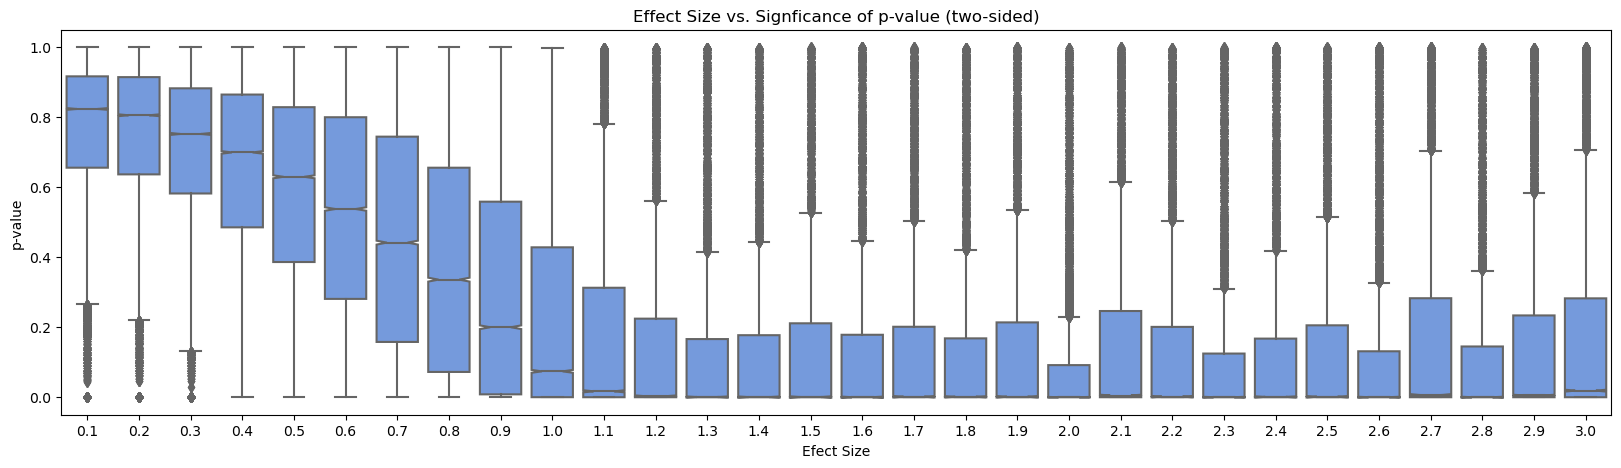

In [42]:
# Vizualize
plt.figure(figsize=(20,5))
sns.boxplot(data=contact_p_path_melt, x="variable", y="value", notch = True, color = "cornflowerblue")
plt.xlabel("Efect Size")
plt.ylabel("p-value")
plt.title("Effect Size vs. Signficance of p-value (two-sided)")
plt.show()

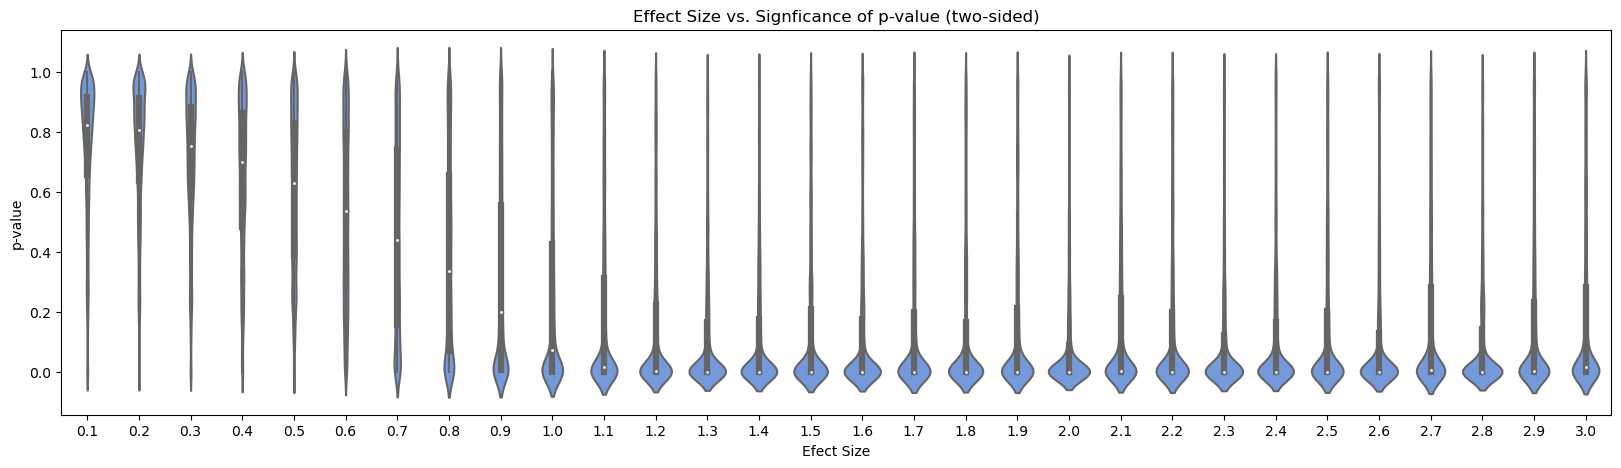

In [43]:
# Vizualize
plt.figure(figsize=(20,5))
sns.violinplot(data=contact_p_path_melt, x="variable", y="value", color = "cornflowerblue")
plt.xlabel("Efect Size")
plt.ylabel("p-value")
plt.title("Effect Size vs. Signficance of p-value (two-sided)")
plt.show()

# Questions, other code, and notes

In [44]:
# Random seed - 
    # set at the beginging of the code; this will make sure code if reproducible (good practice) but need to check what happens with other random seeds
    # Random seeds - bootstrapping, kPCA kernal, simulated data etc. 
    # give it an integret and thats what it starts the random sampling from ; says where in the sequence you stop

In [45]:
#DONT NEED THIS

## Bootstrap multiple times

# n_replicates = 4

# bootstap_list = []
# for i in range(n_replicates):
#     for n in effect_size:
#         resampling_bootstap = effect_size[0].sample(n=263,replace=True, axis=0)
#         bootstap_list.append(resampling_bootstap)
# len(bootstap_list)

# bootstap_list_[1]

In [46]:
# This gives averages across the list of 100 data frames, not each pair - ask Cecilia how i could change it for the pairs in each dataframe

# stacked_mean_and_sd = []
# for m in stack_correlation_matrix_list:
#     mean_correlation = np.mean(m["Correlation_abs"])
#     sd_correlation = np.std(m["Correlation_abs"])
#     stacked_mean_and_sd.append({"Mean" : mean_correlation, "Standard_deviation" : sd_correlation})
#     print(mean_correlation,sd_correlation)

# print(len(stacked_mean_and_sd))
# stacked_mean_and_sd = pd.DataFrame(stacked_mean_and_sd)
# stacked_mean_and_sd


## Trying to do the loop over

## DID AN EASIER WAY

## For one pairway

# corr_values = []
# mean_and_std_list = []
# for m in stack_correlation_matrix_list:
#     correlation_values = m["Correlation_abs"][3]
#     corr_values.append({"Abs_Corr": correlation_values})
#     corr_values_sd_df = pd.DataFrame(corr_values)
#     corr_calc = corr_values_sd_df["Abs_Corr"]

# mean_correlation = statistics.mean(corr_calc) 
# std_correlation = statistics.stdev(corr_calc) 
# mean_and_std_list.append({"Mean": mean_correlation, "Std" : std_correlation})
# mean_and_std_list

In [47]:
# Subplots as having two types of quality
# x = pd.DataFrame(range(0,27225))
# x.columns = ["Number"]
# x

# y = pathway_mean_and_std_df['Mean']
# e = pathway_mean_and_std_df['Std']

# plt.figure(figsize=(35,5))
# plt.errorbar(x, y, e, linestyle='None', marker='^') 
# plt.show()